In [34]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,cos,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,semilogx,semilogy

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [35]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [36]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

def zorder(x):
    w = x.find('L')+1
    m = x[w+4]
    x = int(x[w:w+4])
    if m == 'm':
        return -x
    return x

In [37]:
files = sorted(glob('Calcite/*/*.dat'),key=zorder)

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Calcite/Calibrazione.ini').convolve(1).raw_snip(m=64)
    #spectra.convolve(48).normalize()
    spectra.opt[:] = array([-1157.,51.,1966.])
    spectra.opt_file[:] = array([-1157.,51.,1966.])
    
    spectra.distance = zorder(file)
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(calcite,spectra)]

(0.0, 1280.0)

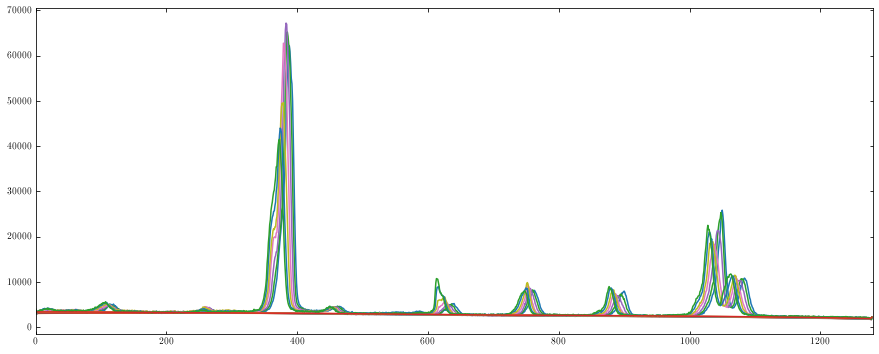

In [38]:
figure(figsize=(15,6))
for s in xrd_spectra:
    plot(s.raw_intensity)
    plot(s.raw_snip)
xlim(0,1280)

[0.29598345 0.85531376 0.3242508  0.45756281 0.52115803 0.69647273
 1.33114036 0.68710809]


array([-1157.28119148,    51.        ,  1966.20720505])

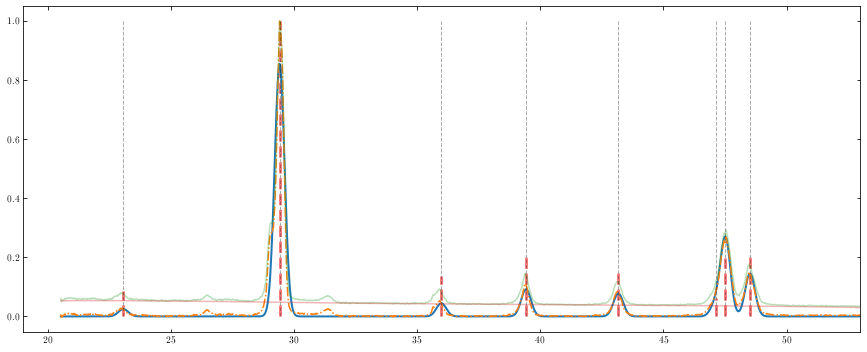

In [39]:
g = xrd_gn[3]
s = xrd_spectra[3]

for _ in range(32):
    g.calibration_nobeta(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
plot(s.theta,s.raw_intensity/s.raw_intensity.max(),'-',alpha=0.33)
plot(s.theta,s.raw_snip/s.raw_intensity.max(),'-',alpha=0.33)
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)
g.spectra.opt

[-1169.47169654    51.          1976.83802512] [9.88419013] -154
[-1166.54517141    51.          1974.66792909] [9.87333965] -104
[-1162.83004049    51.          1971.79259342] [9.85896297] -54
[-1157.28119148    51.          1966.20720505] [9.83103603] 5
[-1154.22257635    51.          1966.40421273] [9.83202106] 57
[-1150.73650862    51.          1967.47054591] [9.83735273] 108
[-1148.40737431    51.          1968.33914258] [9.84169571] 149


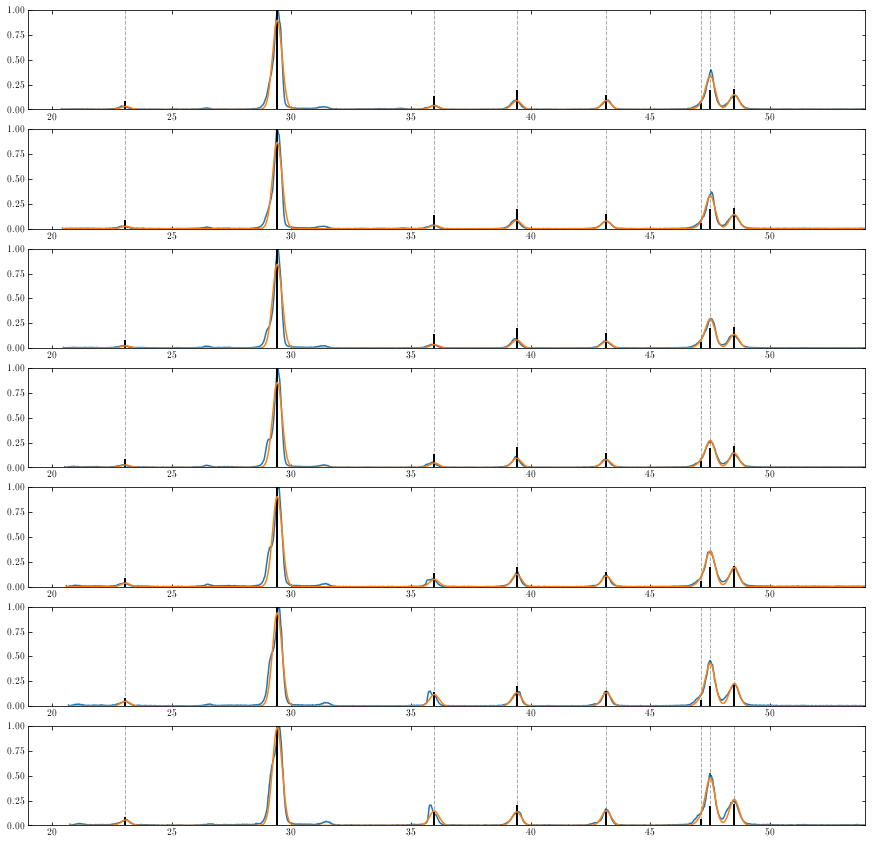

In [40]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration_nobeta(alpha=1)
    print(gn.spectra.opt,gn.spectra.s * 5e-3,gn.spectra.distance)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = calcite.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1169.47169654    51.          1976.83802512] [-1157.    51.  1966.] 9.884190125581494
[-1166.54517141    51.          1974.66792909] [-1157.    51.  1966.] 9.87333964545398
[-1162.83004049    51.          1971.79259342] [-1157.    51.  1966.] 9.85896296711091
[-1157.28119148    51.          1966.20720505] [-1157.    51.  1966.] 9.83103602525537
[-1154.22257635    51.          1966.40421273] [-1157.    51.  1966.] 9.832021063650878
[-1150.73650862    51.          1967.47054591] [-1157.    51.  1966.] 9.837352729555434
[-1148.40737431    51.          1968.33914258] [-1157.    51.  1966.] 9.841695712884931


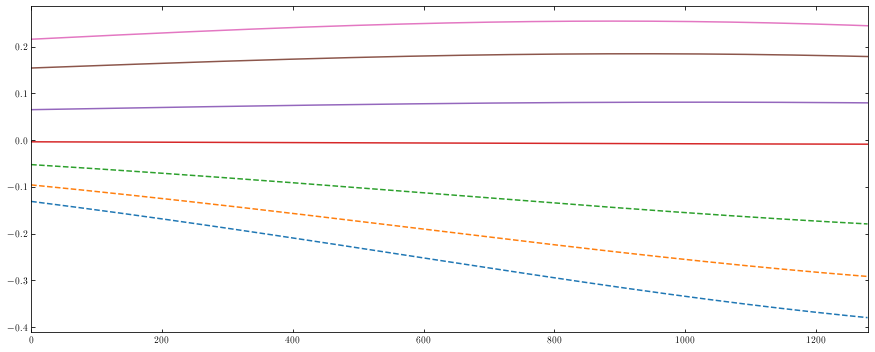

In [41]:
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file,opt[2] * 5e-3)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    ww = '-'
    if gn.spectra.distance < 0:
        ww = '--'
    plot(y_new-y_old,ww)
    xlim(0,1280)


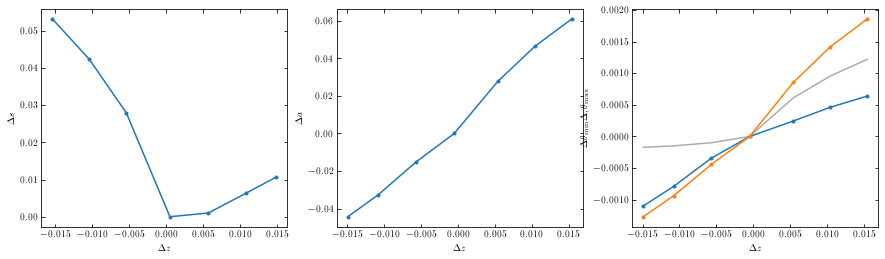

In [42]:
fig,ax = subplots(1,3,figsize=(15,4))
dist = array([gn.spectra.distance for gn in  xrd_gn])
ds = array([gn.spectra.s * 5e-3 for gn in  xrd_gn])
da = array([gn.spectra.a * 5e-3 for gn in  xrd_gn])
da0 = array([(gn.spectra.a + 1280) * 5e-3 for gn in  xrd_gn])

tm = array([gn.spectra.theta[0] * 5e-3 for gn in  xrd_gn])
t0 = array([gn.spectra.theta[-1] * 5e-3 for gn in  xrd_gn])
dt = tm-t0

sbeta = array([sin(gn.spectra.beta / 180 * pi) for gn in  xrd_gn])
cbeta = array([cos(gn.spectra.beta / 180 * pi) for gn in  xrd_gn])

ax[0].plot(dist*1e-4,ds-ds[3],'.-')
ax[0].set_ylabel(r'$\Delta s$')

ax[1].plot(-dist*1e-4,-da+da[3],'.-')
ax[1].set_ylabel(r'$\Delta a$')

ax[2].plot(-dist*1e-4,dt-dt[3],'k-',alpha=0.33)
ax[2].plot(-dist*1e-4,-tm+tm[3],'.-')
ax[2].plot(-dist*1e-4,-t0+t0[3],'.-')
ax[2].set_ylabel(r'$\Delta \theta_{\min} \Delta, \theta_{\max}$')

for a in ax:
    a.set_xlabel(r'$\Delta z$')

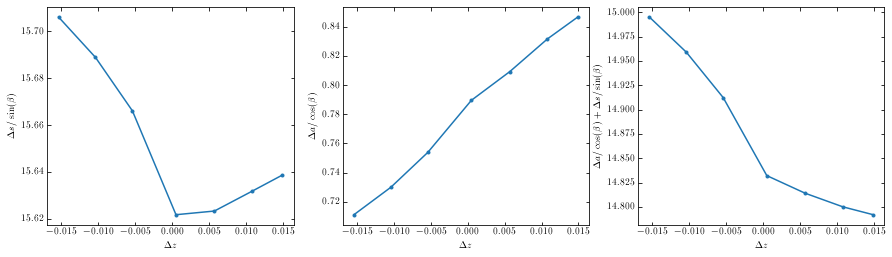

In [47]:
fig,ax = subplots(1,3,figsize=(15,4))

ax[0].plot(dist*1e-4,ds/cbeta,'.-')
ax[0].set_ylabel(r'$\Delta s/\sin(\beta)$')

ax[1].plot(dist*1e-4,da0/sbeta,'.-')
ax[1].set_ylabel(r'$\Delta a/\cos(\beta)$')

ax[2].plot(dist*1e-4,ds/cbeta - da0/sbeta,'.-')
ax[2].set_ylabel(r'$\Delta a /\cos(\beta) + \Delta s /\sin(\beta)$')

for a in ax:
    a.set_xlabel(r'$\Delta z$')

(0.0, 1280.0)

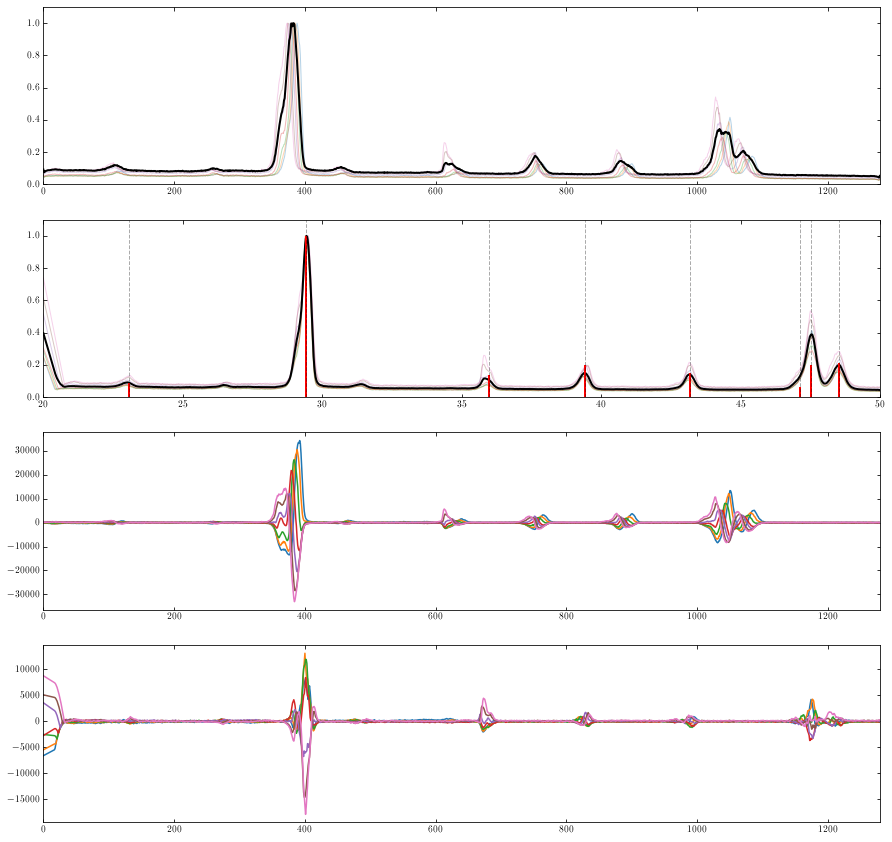

In [31]:
fig,ax = subplots(4,1,figsize=(15,15))

x = linspace(20,50,1280)
z0 = zeros(1280)
lenx = len(x)
z = zeros(len(x))

for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ax[0].plot(s.channel,s.raw_intensity/s.raw_intensity.max(),alpha=0.33,lw=1)
    z0 += s.raw_intensity
z0 /= len(xrd_gn)
ax[0].plot(s.channel,z0/z0.max(),'k',lw=2)
ax[0].set_xlim(0,1280)
ax[0].set_ylim(0,1.1)

for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    fce_i1d = interp1d(s.theta,s.raw_intensity,fill_value='extrapolate')
    y = fce_i1d(x)
    s.y = y
    ax[1].plot(x,y/y.max(),alpha=0.33,lw=1)
    z += y
z /= len(xrd_gn)
    
ax[1].plot(x,z/z.max(),'k-',lw=2)
ax[1].set_xlim(20,50)
ax[1].set_ylim(0,1.1)

x,y = calcite.get_theta(max_theta = 53,min_intensity=0.05)
ax[1].vlines(x,0,y,'r',lw=2)
ax[1].vlines(x,0,1.1,'k',lw=1,ls='--',alpha=0.33)

h0 = []
std0 = []
mean0 = []
for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ds = s.raw_intensity - z0
    ax[2].plot(ds)
    h0 += [histogram(ds,bins=200,range=(-40,40))]
    std0 += [ds.std()]
    mean0 += [ds.mean()]
ax[2].set_xlim(0,1280)

h1 = []
std1 = []
mean1 = []
for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ds = s.y - z
    h1 += [histogram(ds,bins=200,range=(-40,40))]
    std1 += [ds.std()]
    mean1 += [ds.mean()]
    ax[3].plot(ds)
ax[3].set_xlim(0,lenx)

(0.0, 5.0)

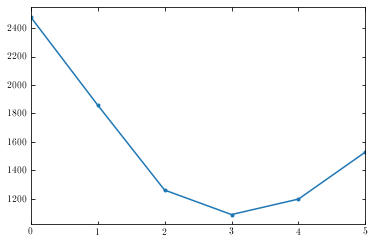

In [32]:
plot(array(std0)-array(std1),'.-')
xlim(0,5)

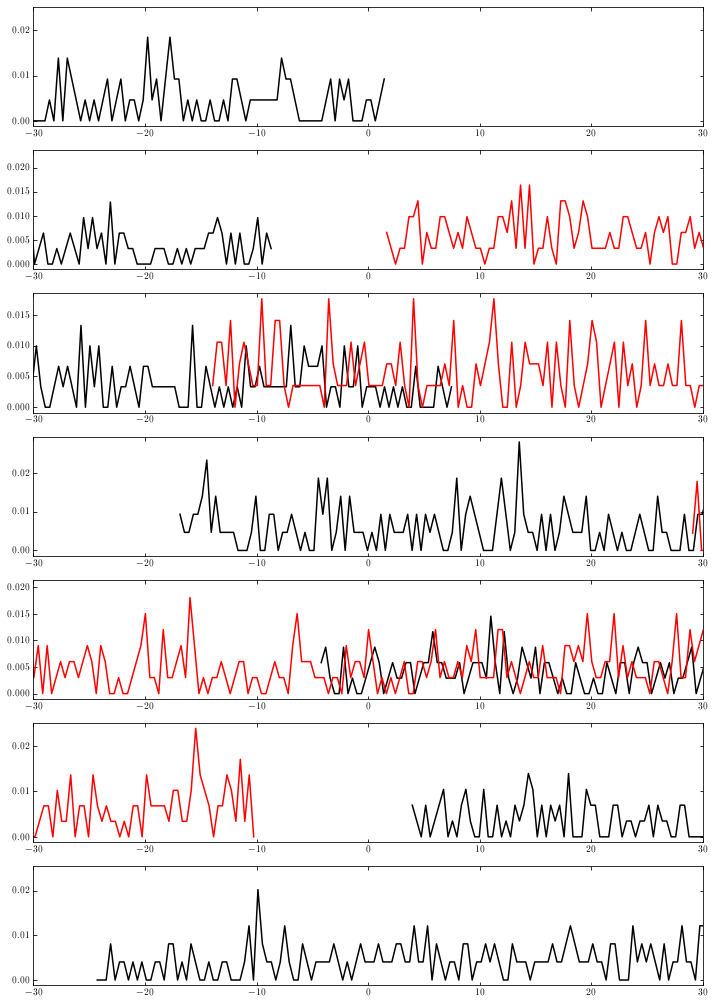

In [33]:
fig,ax = subplots(len(std0),1,figsize=(12,18))
for i,((h,b),m) in enumerate(zip(h0,mean0)):
    b = b[:-1]
    ax[i].plot(b-m,h/h.sum(),'k-')
    
for i,((h,b),m) in enumerate(zip(h1,mean1)):
    b = b[:-1]
    ax[i].plot(b-m,h/h.sum(),'r-')
    ax[i].set_xlim(-30,30)